<a href="https://colab.research.google.com/github/ProjectFace2/reservoirOutflow/blob/master/Ensemble_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# import warnings
# warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"
import pandas as pd
import numpy as np
from numpy import concatenate
from datetime import datetime
import matplotlib as mpl
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import fbprophet as fb
import pickle

dataset 

In [17]:
def sense_val_inflow(x):
    if(x <= 500):
        return 0
    elif((x > 500) and (x<=1000)):
        return 1
    elif((x > 1000) and (x<=2500)):
        return 2
    elif((x > 2500) and (x<=5000)):
        return 3
    elif((x > 5000) and (x <= 7000)):
        return 4
    elif((x > 7000) and (x <= 11000)):
        return 5
    elif((x > 11000) and (x <= 22000)):
        return 6
    elif(x > 22000):
         return 7

In [2]:
'''
In this method, we use all the lag days and lead days and construct a dataframe, where
the lag and lead days are represented in a single row
Using these features we can predict the class of the present day with the data from the previous days
This holds good for all the rows in the dataframe
'''

#dataset preparation with lag
def series_to_supervised(data, lag_days=1, lead_days=1, dropnan=True):
    no_of_features = 1 if type(data) is list else data.shape[1]
    print(no_of_features)
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(lag_days, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(no_of_features)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, lead_days):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(no_of_features)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(no_of_features)]
# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
class LocallyWeightedRegression:
    def __init__(self):
        return
        
    def setup(self,X,y):
        lag_val = int(X.shape[1]/4)
        begin_year = ''
        if(lag_val==9):
            begin_year='2011-01-10'
        else:
            begin_year='2011-01-05'
        self.train_x,self.train_y = self.init_train( lag_val, begin_year)

    def fit(self, train_x, train_y):
        self.setup(train_x,train_y)

    def init_train( self, lag_val=4, begin_year='2011-01-05'):
        df = pd.read_csv('/home/kishora/Documents/Datasets/allYearLabeledHarangi.csv',header=0,parse_dates=True,index_col=0)
        x=df.drop(["Present Storage(TMC)",'Reservoir Level(TMC)','Outflow','Label'],axis = 1)
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = self.scaler.fit_transform(x.values)
        reshaped=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})
        idx = pd.date_range('2011-01-01', '2018-12-31') 
        reshaped['Dates']=idx
        df=reshaped
        df['month'] = pd.DatetimeIndex(df["Dates"]).month
        df['year'] = pd.DatetimeIndex(df["Dates"]).year
        mask = (df['month'] <= 12)
        mask1 = (df['year'] >= 2011)&(df['year'] <= 2018)
        df = df.loc[mask]
        df = df.loc[mask1]
        df.set_index('Dates',inplace = True)
        df.drop(['month','year'],axis = 1,inplace = True)
#         lag_val = 4
        values = df.values
        values = values.astype('float32')
        reframed = series_to_supervised(values, lag_val, 1)#lag of 4 days
        reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
        idx = pd.date_range(begin_year, '2018-12-31') 
        reframed['Dates']=idx
        reframed['month']=pd.DatetimeIndex(reframed['Dates']).month
        reframed=reframed.sort_values(by=['month','Dates'])
        reframed.drop(columns=['month','Dates'],inplace=True)
        values = reframed.values
        train_x = values[:,:-1]
        Inflow = values[:,-1]
        train_y = Inflow.reshape((train_x.shape[0],1))
        return train_x,train_y
   
    #locally weighted regression

    def lwr1(self,x0, inp, out, k):
        m,n = np.shape(inp)
        ypred = np.zeros(m)    
        ypred = x0 * self.beta(x0, inp, out, k)
        #print("The final prediction is :",ypred)
        return ypred
    
    def beta(self,point, inp, out, k):
        wt = self.kernal(point, inp, k)
        #print("The weight of betas is",wt)
        beta_val = (inp.T * (wt*inp)).I * inp.T * wt * out
        #print("The weight is beta value is",beta_val)
        return beta_val
    
    def kernal(self,point, inp, k):
        l,b = np.shape(inp)
        weights = np.mat(np.eye((l)))
        #print(weights)    
        for i in range(l):
            #print(point.shape,inp[i].shape)
            diff = point - inp[i]
            weights[i,i] = np.exp(np.dot(diff,diff.T) / (-2.0 * (k**2)))
        return weights
    
    def call_Lwr(self, test_x,train_x,train_y,k=0):
            ypred = []
            train_X = train_x
            train_y = train_y
            for i in test_x:
                ypred.append(self.lwr1(i, train_X, train_y, 7.15))
            ypred = np.array(ypred).reshape(len(ypred),1)
            inv_yhat = np.concatenate((ypred, test_x[:, -3:]), axis=1)
            out=self.scaler.inverse_transform(inv_yhat) 
            out=out[:,0]
            return out

    def predict(self, test_x):
        return self.call_Lwr(test_x,self.train_x,self.train_y)

In [4]:
def predict(queryset,date):
    '''based on query set ,and given date range predicts result for given date with multiple models and returns ensembled result 
    query set can be single row or multiple row set, in case of multiple set use dataframe range with set of prediction seeking dates 
    '''
    # lstm prediction
    n_hours = 9
    n_features = 4
    test_x=queryset.values
    lstm_test_X = test_x.reshape((test_x.shape[0], n_hours, n_features))
    with open('/home/kishora/Documents/models/lstmInf_forecast_model_lag9.pckl', 'rb') as fin:
        lstm_lag9_model = pickle.load(fin)
    lstm_inv_yhat=lstm_lag9_model.predict(lstm_test_X)
    test_X = lstm_test_X.reshape((lstm_test_X.shape[0], n_hours*n_features))
    inv_yhatx = concatenate((lstm_inv_yhat, test_X[:, -3:]), axis=1)
    inv_yhaty = scaler.inverse_transform(inv_yhatx)
    lstm_res = inv_yhaty[:,0]

    # fb prophet prediction
    fb_test=queryset.copy()
    varList=fb_test.columns.tolist()
    varList.insert(0,'ds')
    fb_test['ds']=date
    fb_test_X = pd.DataFrame(fb_test[varList])
    with open('/home/kishora/Documents/models/fbInf_forecast_model_lag9.pckl', 'rb') as fin:
        proph_lag9_model = pickle.load(fin)
    proph_inv_yhat = proph_lag9_model.predict(fb_test_X).values
    proph_res = proph_inv_yhat[:,-1]

  # lwr prediction
    lwr_test=queryset.values
  # print(lwr_test.shape,queryset.values.shape)
    with open('/home/kishora/Documents/models/lwrInf_forecast_model_lag9.pckl', 'rb') as fin:
        lwr_lag9_model = pickle.load(fin)
    lwr_res = lwr_lag9_model.predict(lwr_test)

  # ensembled prediction
    inp=pd.DataFrame()
    inp['lstm']=lstm_res
    inp['proph']=proph_res
    inp['lwr']=lwr_res
    with open('ensembled_forecast_model_lag9.pckl', 'rb') as fin:
        en_lag9_model = pickle.load(fin)
    predictions=pd.DataFrame()
    predictions['lower']=en_lag9_model[0].predict(inp[['lstm','proph','lwr']])
    predictions['result']=en_lag9_model[1].predict(inp[['lstm','proph','lwr']])
    predictions['upper']=en_lag9_model[2].predict(inp[['lstm','proph','lwr']])
    return predictions



In [5]:
df = pd.read_csv('/home/kishora/Documents/Datasets/allYearHarangi.csv',index_col=0)
df.drop(["Present Storage(TMC)",'Reservoir Level(TMC)','Outflow'],axis = 1,inplace = True)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)
reshaped=pd.DataFrame({'Inflow':scaled[:,0],'MADIKERI':scaled[:,1],'SOMWARPET':scaled[:,2],'VIRAJPET':scaled[:,3]})


In [6]:
x=reshaped.values
qwtest=series_to_supervised(x,9,1)
qwtest.drop(qwtest.columns[[-1,-2,-3]], axis=1, inplace=True)
qwtest_x=qwtest.iloc[-1087:,:-1]
qwtest_y=qwtest.values[-1087:,-1:]
dates = pd.date_range('2016-01-10','2018-12-31')

4


In [10]:
test_X = qwtest_x.values.reshape((qwtest_x.shape[0], 9*4))
inv_yhatx = concatenate((qwtest_y, test_X[:, -3:]), axis=1)
inv_yhaty = scaler.inverse_transform(inv_yhatx)
out = inv_yhaty[:,0]

In [8]:
predictions=predict(qwtest_x,dates)

In [13]:
predictions['actual']=out
predictions['actualLabel']=predictions.actual.apply(sense_val_inflow)
predictions['lowLabel']=predictions.lower.apply(sense_val_inflow)
predictions['midlabel']=predictions.result.apply(sense_val_inflow)
predictions['uplabel']=predictions.upper.apply(sense_val_inflow)

#ensembled lower limit

In [29]:
print("lowlabel ",100*recall_score(predictions['actualLabel'],predictions['lowLabel'],average='weighted'))
print("lowlabel ",100*precision_score(predictions['actualLabel'],predictions['lowLabel'],average='weighted'))
print("lowlimit classification f1 score ",100*f1_score(predictions['actualLabel'],predictions['lowLabel'],average='weighted'),"%")

lowlabel  76.72493100275989
lowlabel  72.42150340404893
lowlimit classification f1 score  74.12605622665977 %


#ensembled regression output

In [30]:
print("midlabel ",100*recall_score(predictions['actualLabel'],predictions['midlabel'],average='weighted'))
print("midlabel ",100*precision_score(predictions['actualLabel'],predictions['midlabel'],average='weighted'))
print("final classification f1 score ",100*f1_score(predictions['actualLabel'],predictions['midlabel'],average='weighted'),"%")

midlabel  87.4885004599816
midlabel  88.09173424916817
final classification f1 score  87.66128733755345 %


#ensembled upper limit

In [31]:
print("uplabel ",100*recall_score(predictions['actualLabel'],predictions['uplabel'],average='weighted'))
print("uplabel ",100*precision_score(predictions['actualLabel'],predictions['uplabel'],average='weighted'))
print("upper limit classification f1 score ",100*f1_score(predictions['actualLabel'],predictions['uplabel'],average='weighted'),"%")

uplabel  78.196872125115
uplabel  80.38949313764219
upper limit classification f1 score  78.5840366005228 %


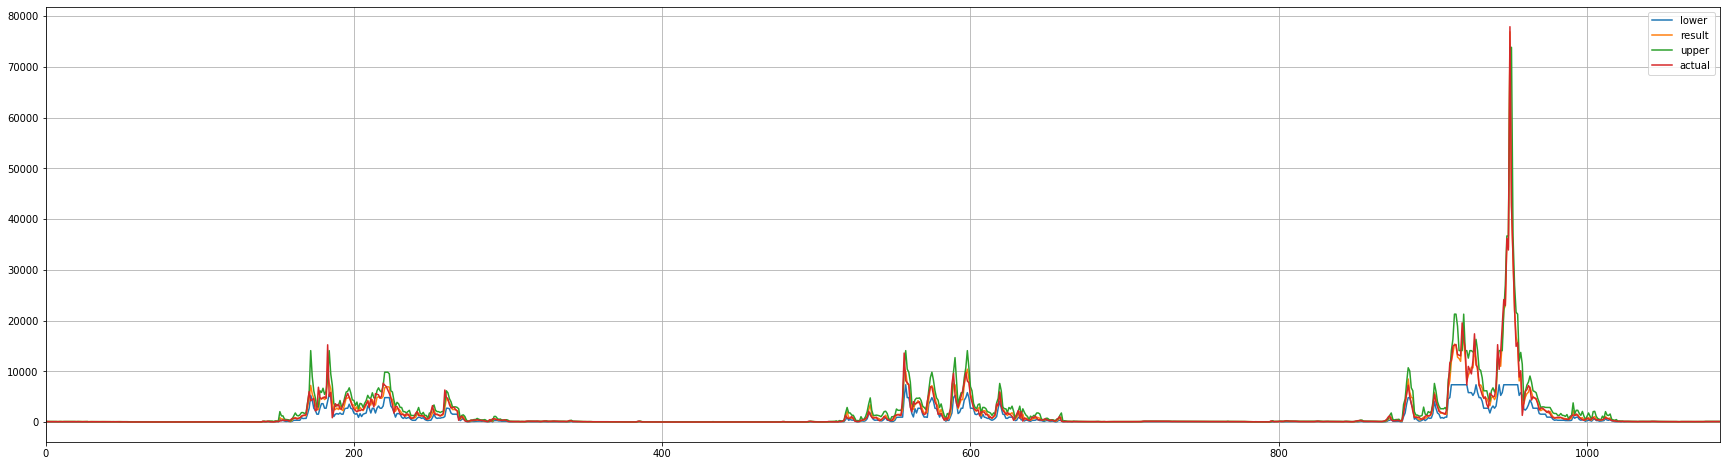

In [14]:
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True
predictions.plot()


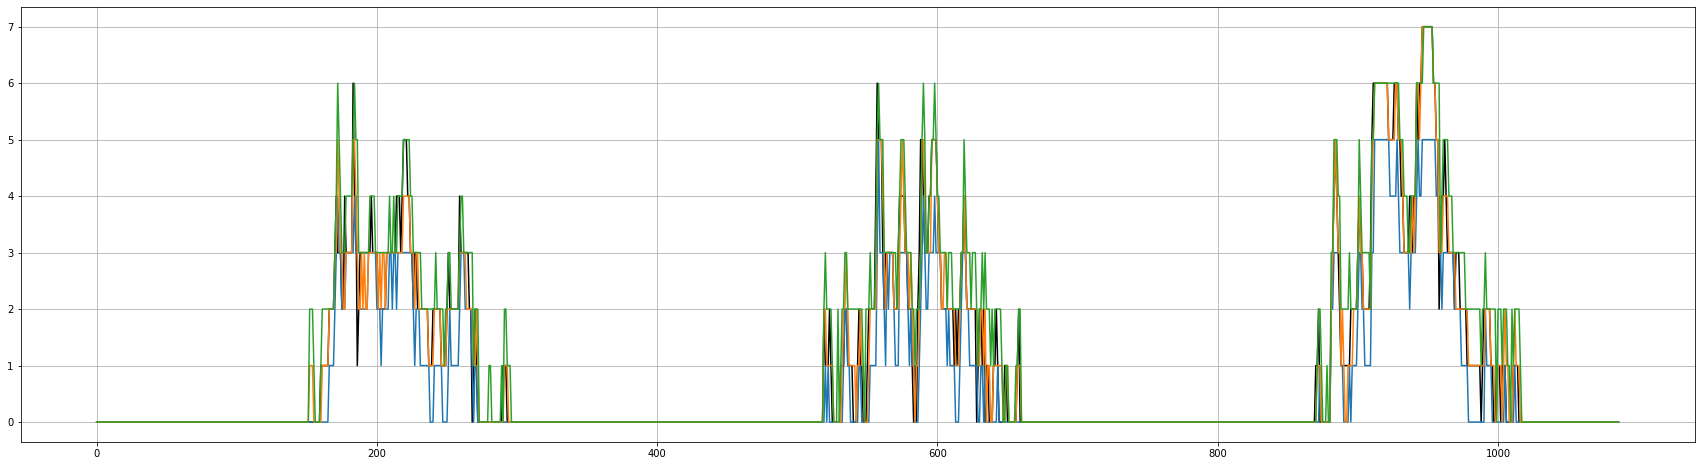

In [26]:
pyplot.plot(predictions['actualLabel'],color='black')
pyplot.plot(predictions['lowLabel'])
pyplot.plot(predictions['midlabel'])
pyplot.plot(predictions['uplabel'])